Mounted at /content/drive


5774

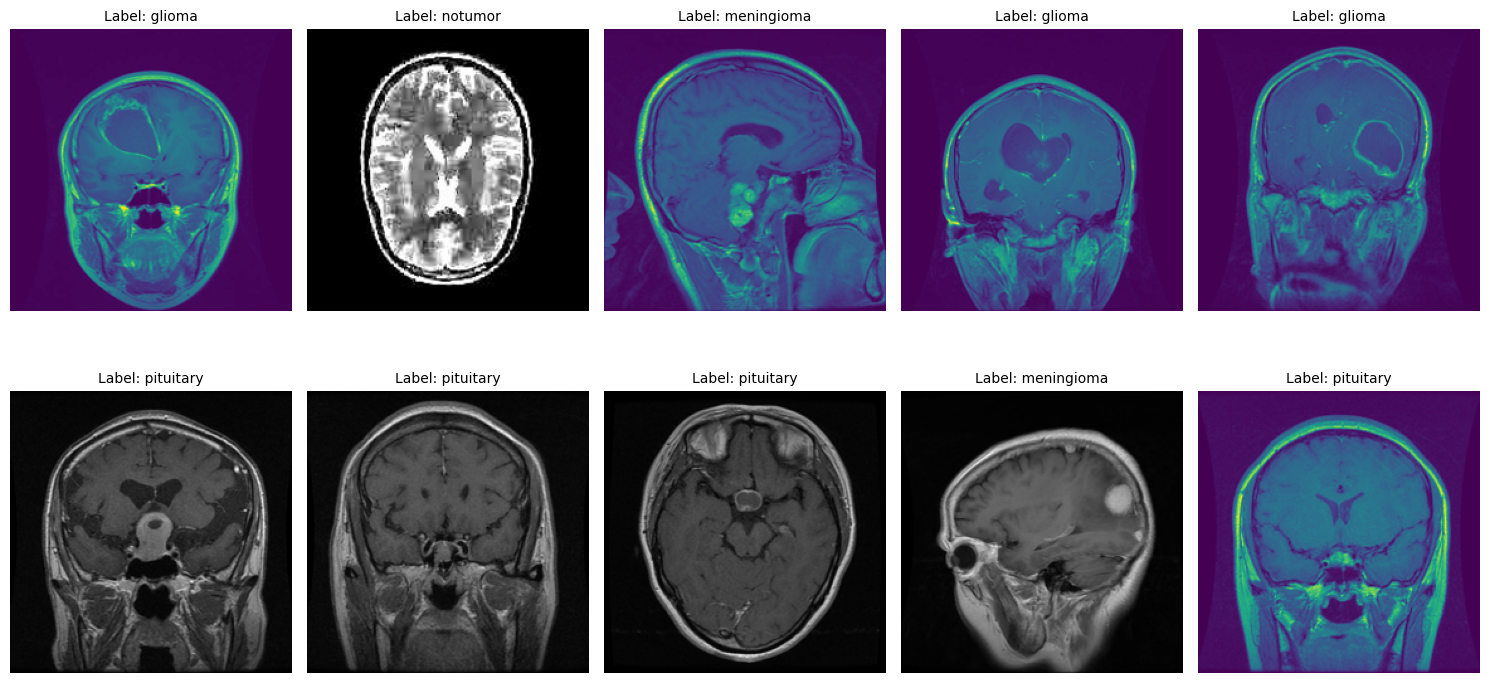

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 689ms/step - loss: 1.1827 - sparse_categorical_accuracy: 0.4841
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 654ms/step - loss: 0.6033 - sparse_categorical_accuracy: 0.7647
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 750ms/step - loss: 0.4431 - sparse_categorical_accuracy: 0.8301
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 702ms/step - loss: 0.4912 - sparse_categorical_accuracy: 0.7947
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 589ms/step - loss: 0.4206 - sparse_categorical_accuracy: 0.8256


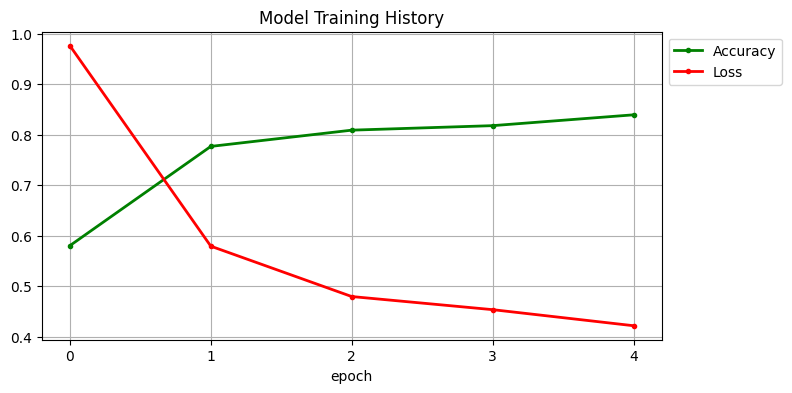

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


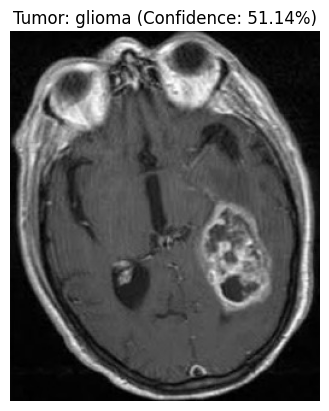

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


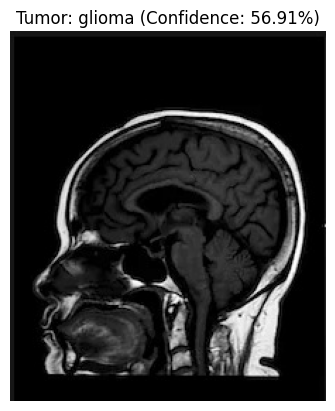

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


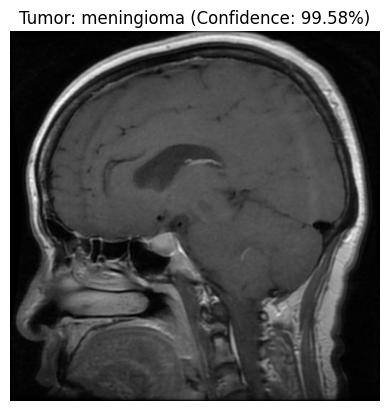

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


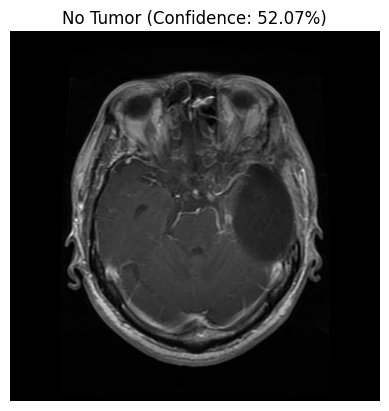

In [1]:
from google.colab import files
files.upload()  # you'll be prompted to upload your kaggle.json

# 3. Configure credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download the dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
import zipfile
with zipfile.ZipFile('brain-tumor-mri-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('brain_tumor')

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 84% 125M/149M [00:00<00:00, 1.31GB/s]
100% 149M/149M [00:00<00:00, 1.22GB/s]


In [ ]:
import os
import numpy as np
import random
from PIL import Image,ImageEnhance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

test_dir='/content/brain_tumor/Testing'
train_dir='/content/brain_tumor/Training'
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)
len(train_paths)

5712

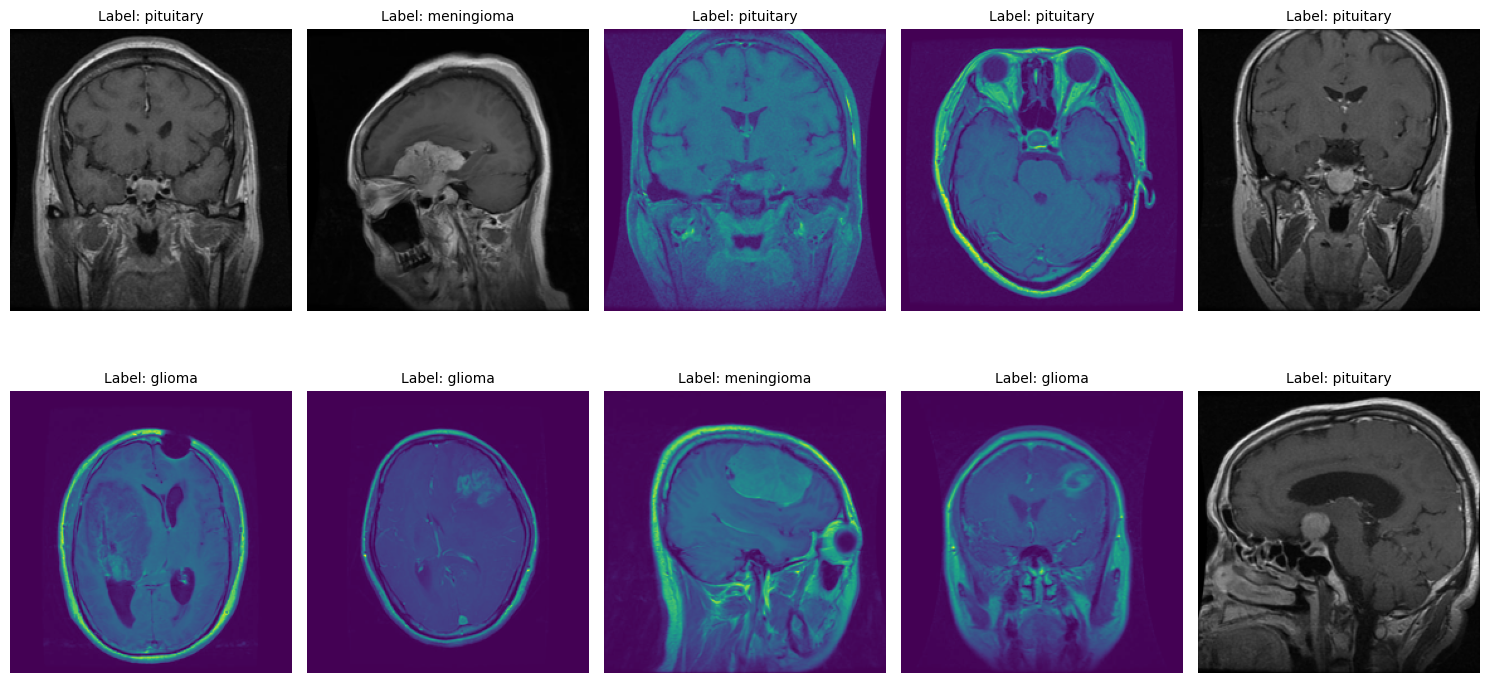

In [ ]:

import random
import matplotlib.pyplot as plt
from PIL import Image
import os


# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [ ]:
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int((len(train_paths) / batch_size)  )# Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.7460
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - loss: 0.2552 - sparse_categorical_accuracy: 0.9041
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.9369
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.9530
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - loss: 0.0817 - sparse_categorical_accuracy: 0.9664


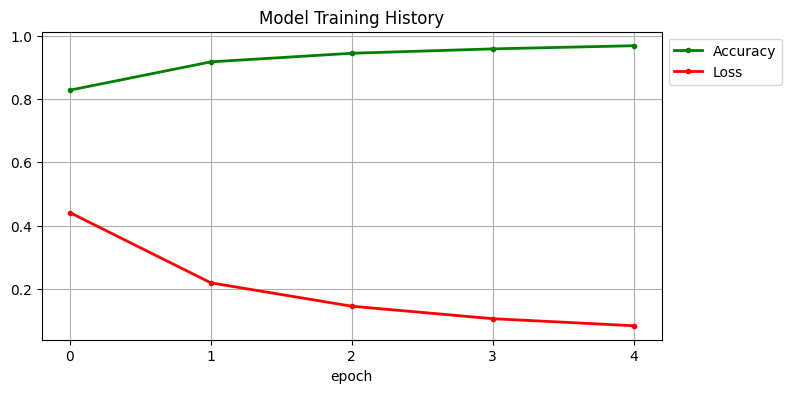

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['meningioma','notumour','pituitary','glioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        print(predicted_class_index)
        print(class_labels[predicted_class_index])
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
3
glioma


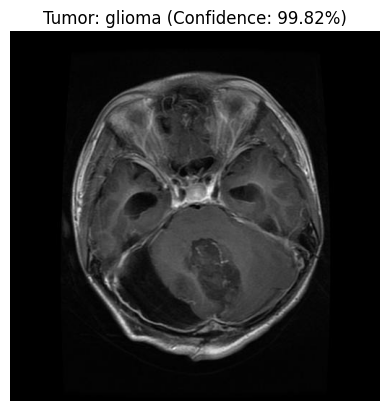

In [ ]:
image_path = '/content/brain_tumor/Testing/glioma/Te-glTr_0000.jpg' # Provide the path to your new image
detect_and_display(image_path, model)

Confusion Matrix:
[[303   1   1   1]
 [  5 400   0   0]
 [  4   0 296   0]
 [ 49   0   0 251]]


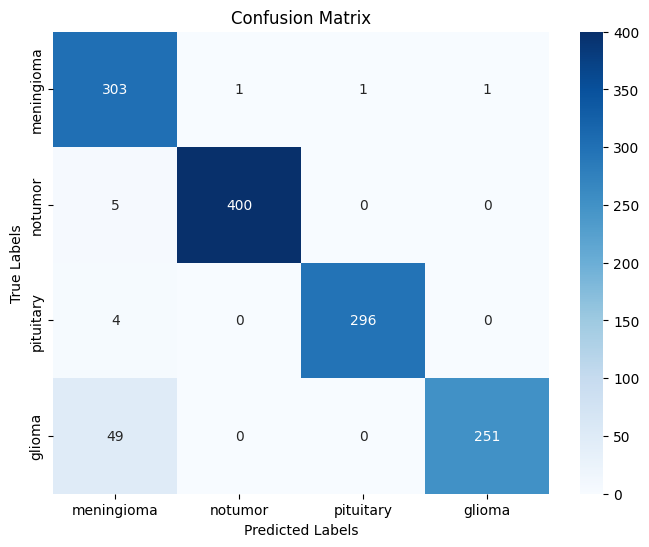

In [ ]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       306
           1       1.00      0.99      0.99       405
           2       1.00      0.99      0.99       300
           3       1.00      0.84      0.91       300

    accuracy                           0.95      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
# model = load_model('model.h5')

model.save('brain_tumor_model.h5')
from google.colab import files
files.download('brain_tumor_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>